### Group: SAXA 4
### Bassma Ali · Andrew Singh · Andy Oliver · Destiny Floyd-McGuiness . Vahid Dabbaghi Sadr

### Notebook 08 — Inference and Risk Prediction Pipeline

### 1. Purpose of This Notebook

This notebook implements the **inference layer** for the SAXA 4 Capstone Project.  
While earlier notebooks focused on data exploration, preprocessing, feature engineering, and model development, this notebook provides the final step: creating a reusable function that can classify new AI use-case narratives.

Specifically, this notebook will:

- Load the trained TF–IDF vectorizer, Logistic Regression model, LabelEncoder, and text-cleaning function saved in Notebook 07.
- Define a function that accepts raw narrative text as input.
- Apply the same cleaning and vectorization used during training.
- Produce a predicted impact type and probability scores for each class.
- Return a structured output format that can be consumed by downstream tools, including LLM-based report generation.

This notebook represents the *deployment-ready* component of the end-to-end pipeline.

### 2. Impact Type Definitions

The classifier predicts one of four standardized governance impact categories as defined in the Federal AI Use Case Inventory:

#### 2.1 Neither  
Use case does not appear to create meaningful risks to rights or safety.  
Most administrative, low-risk automation scenarios fall here.

#### 2.2 Both  
Use case may create potential risks to both rights and safety.  
Common examples include monitoring systems, biometric analysis, or predictive models that influence human outcomes.

#### 2.3 Rights  
Use case may significantly affect civil rights, civil liberties, privacy, or due process.  
Examples include identity verification, eligibility determination, content moderation, biometric identification, and similar applications.

#### 2.4 Safety  
Use case may significantly affect physical or operational safety.  
This class is extremely rare in the dataset (only ~16 examples), which limits model performance.

### 3. What the Prediction Function Will Do

In this notebook, we will define a function called `predict_impact(text)` that performs:

1. Text cleaning using the same preprocessing steps defined in Notebook 01 (via `basic_clean()`).
2. TF–IDF vectorization using the saved vectorizer.
3. Prediction using the final Logistic Regression model.
4. Decoding the numerical prediction back into a readable class label using the LabelEncoder.
5. Returning class probability scores using `predict_proba()`.
6. Packaging results into a structured dictionary for downstream use.

The expected output format will be:

{
"predicted_class": "rights",
"confidence": 0.82,
"class_probabilities": {
"both": 0.03,
"neither": 0.10,
"rights": 0.82,
"safety": 0.05
}
}

This output can be used directly in LLM-powered narrative generation, governance scoring, dashboards, or reporting tools.

### 4. Artifacts Loaded in This Notebook

This notebook loads the following artifacts produced in Notebook 07:

- `vectorizer_final.joblib` — trained TF–IDF vectorizer  
- `log_reg_final.joblib` — final, best-performing Logistic Regression model  
- `label_encoder_final.joblib` — label encoder mapping numeric classes to text labels  
- `basic_clean.py` — the exact text-cleaning function used during preprocessing

These artifacts ensure that inference uses **identical preprocessing and feature space** as the training pipeline.

### 5. End State of This Notebook

After completing Notebook 08, we will have:

- A fully functional classifier for new AI use-case narratives.
- Probability-based predictions suitable for thresholding or confidence scoring.
- A clean function ready to be wrapped by:
  - A simple UI
  - A downstream pipeline
  - An LLM for automated narrative risk reporting
- A complete, end-to-end governance impact prediction pipeline.

In [1]:
# 1: Core imports for inference

import joblib
import numpy as np


# Import the text cleaning function from the file saved in Notebook 07
from basic_clean import basic_clean

ModuleNotFoundError: No module named 'basic_clean'

In [ ]:
# 2: Define paths to saved artifacts and load them

# If your notebook is in the same folder as the artifacts, these can stay as-is.
# Otherwise, update the paths accordingly (e.g., "models/vectorizer_final.joblib").

VECTORIZER_PATH = "vectorizer_final.joblib"
LOGREG_MODEL_PATH = "log_reg_final.joblib"
LABEL_ENCODER_PATH = "label_encoder_final.joblib"

# Load TF–IDF vectorizer
vectorizer = joblib.load(VECTORIZER_PATH)

# Load Logistic Regression model
log_reg = joblib.load(LOGREG_MODEL_PATH)

# Load LabelEncoder
le = joblib.load(LABEL_ENCODER_PATH)

print("Artifacts loaded successfully.")


Artifacts loaded successfully.


In [ ]:
def extract_top_tfidf_keywords(model, vectorizer, text, top_n=8):
    """
    Returns top weighted TF-IDF features influencing the prediction
    for logistic regression.
    """
    import numpy as np  # <-- inside the function

    # Vectorize input text
    X = vectorizer.transform([text])

    # Feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Coefficients for each class
    coefs = model.coef_

    # Predicted class
    pred_class = model.predict(X)[0]
    class_index = list(model.classes_).index(pred_class)

    # Contribution = tfidf_value * coefficient
    contributions = X.toarray()[0] * coefs[class_index]

    # Top N features
    top_idx = contributions.argsort()[::-1][:top_n]
    return feature_names[top_idx].tolist()

In [ ]:
# # 3: Sanity check to verify the loaded objects

print("Vectorizer type:", type(vectorizer))
print("Logistic model type:", type(log_reg))
print("Label encoder classes:", le.classes_)

# Optional: check vocabulary size
print("TF-IDF vocabulary size:", len(vectorizer.get_feature_names_out()))

# Test prediction on a dummy text
test_text = "This system uses AI to monitor safety operations and detect hazardous conditions."
cleaned = basic_clean(test_text)
pred = log_reg.predict(vectorizer.transform([cleaned]))[0]
print("Test prediction label:", pred)

# Test top keyword extraction
keywords = extract_top_tfidf_keywords(log_reg, vectorizer, cleaned)
print("Top influencing keywords:", keywords)

Vectorizer type: <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
Logistic model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Label encoder classes: ['both' 'neither' 'rights' 'safety']
TF-IDF vocabulary size: 8705
Test prediction label: 1
Top influencing keywords: ['conditions', 'safety', 'uses', 'zones', 'fabricated inaccurate', 'fabricated', 'faa', 'eyes']


In [ ]:
# 4: Define unified prediction function for new text

# This function:
# - Takes a raw narrative text string as input
# - Cleans the text using basic_clean()
# - Vectorizes it using the saved TF-IDF vectorizer
# - Runs prediction using the final Logistic Regression model
# - Decodes the numeric class label using the LabelEncoder
# - Returns:
#       predicted_class       → the most likely impact type
#       confidence            → probability of the predicted class
#       class_probabilities   → probabilities for all classes
#       cleaned_input         → the exact cleaned text used for prediction
#       predicted_index       → numeric index of predicted class (useful for Streamlit / LLM)
#
# Uses artifacts loaded earlier:
#   basic_clean     → text cleaning
#   vectorizer      → TF-IDF transform
#   log_reg         → final trained classifier
#   le              → label decoder
#
# Notes:
# - Imports numpy inside the function (self-contained)
# - Handles empty input safely (prevents Streamlit crashes)
# - Keeps rounding consistent with earlier outputs

def predict_impact(text: str):

    import numpy as np  # local import for portability

    # Handle empty input gracefully
    if text is None or str(text).strip() == "":
        return {
            "predicted_class": None,
            "confidence": 0.0,
            "class_probabilities": {},
            "cleaned_input": "",
            "predicted_index": None
        }

    # 1. Clean the text with the same process used during training
    cleaned_text = basic_clean(text)

    # 2. Transform the cleaned text into TF-IDF features
    X_new = vectorizer.transform([cleaned_text])

    # 3. Get probability scores from Logistic Regression
    proba = log_reg.predict_proba(X_new)[0]

    # 4. Identify the predicted class
    pred_idx = int(np.argmax(proba))
    pred_label = le.inverse_transform([pred_idx])[0]

    # 5. Format class probabilities (rounded)
    class_probabilities = {
        class_label: float(round(prob, 4))
        for class_label, prob in zip(le.classes_, proba)
    }

    return {
        "predicted_class": pred_label,
        "confidence": float(round(proba[pred_idx], 4)),
        "class_probabilities": class_probabilities,
        "cleaned_input": cleaned_text,
        "predicted_index": pred_idx
    }

print("Prediction function updated and ready.")


Prediction function updated and ready.


In [ ]:
# 5: First test of the prediction pipeline
test_text = """
The system uses biometric identification and continuous monitoring to verify individuals
and determine eligibility for services. It processes sensitive personal information
and may affect rights if misclassified.
"""

result = predict_impact(test_text)
result


{'predicted_class': 'neither',
 'confidence': 0.4807,
 'class_probabilities': {'both': 0.1391,
  'neither': 0.4807,
  'rights': 0.2995,
  'safety': 0.0808},
 'cleaned_input': 'the system uses biometric identification and continuous monitoring to verify individuals and determine eligibility for services. it processes sensitive personal information and may affect rights if misclassified.',
 'predicted_index': 1}

***

### Notebook 09 — Batch Predictions, Thresholds, and Risk Flags

#### Goal
Use the trained Logistic Regression model to score **all rows** in `final_data_preprocessed.csv`, add probability-based risk flags, and create a dataset ready for Deloitte-style analysis.

#### Workflow Overview

1. **Setup & Artefacts**
   - Import packages.
   - Load:
     - `final_data_preprocessed.csv`
     - `vectorizer_final.joblib`
     - `log_reg_final.joblib`
     - `label_encoder_final.joblib`
     - `basic_clean.py`

2. **Prepare Text for Scoring**
   - Use `TEXT_COL = "text_clean"`.
   - Apply `basic_clean()` to create a clean text column for modelling (if needed).

3. **Batch Vectorization & Prediction**
   - Transform all cleaned text with the saved TF–IDF vectorizer.
   - Use Logistic Regression to:
     - Predict class (`neither`, `rights`, `safety`, `both`).
     - Get probabilities for each class.

4. **Attach Predictions to DataFrame**
   - Add:
     - `predicted_class`
     - `predicted_confidence` (max probability)
     - `prob_neither`, `prob_rights`, `prob_safety`, `prob_both`.

5. **Define Threshold Rules**
   - Choose simple thresholds, e.g.:
     - `rights_high` if `prob_rights >= 0.70`
     - `safety_high` if `prob_safety >= 0.70`
     - `both_high` if `prob_both >= 0.50`
   - Create Boolean flag columns:
     - `flag_rights_high`, `flag_safety_high`, `flag_both_high`
     - `flag_any_high_risk` (OR of the three)

6. **Optional: Compare to Reported Impact**
   - If `17_impact_type` is present:
     - Create `prediction_matches_reported`.
     - Create `flag_underreported_risk` where model predicts risk but reported label is `neither` or missing.

7. **Export Scored Dataset**
   - Save as `scored_ai_inventory_with_risk_flags.csv`.
   - This file is the main input for:
     - risk summaries,
     - dashboards,
     - and LLM-generated narratives.

***

### Batch scoring

In [ ]:
import pandas as pd

# 1. Load data used for modelling
DATA_PATH = "final_data_preprocessed.csv"
TEXT_COL = "text_clean"

df = pd.read_csv(DATA_PATH)

# 2. Apply predict_impact() to every row
results_series = df[TEXT_COL].astype(str).apply(predict_impact)

# 3. Expand dicts to columns
results_df = pd.json_normalize(results_series)

# 4. Prefix model columns and join back to original data
results_df = results_df.add_prefix("model_")
df_scored = pd.concat([df, results_df], axis=1)

# 5. Quick check
df_scored[[TEXT_COL, "model_predicted_class", "model_confidence"]].head()

,text_clean,model_predicted_class,model_confidence
0,"utilizes ai/ml to generate high resolution, ra...",neither,0.4713
1,cbp uses this tool to conduct targeted queries...,rights,0.5890
2,the system enhances cbp's capability to monito...,rights,0.5612
3,aaxi aims to address the problem of anomaly de...,rights,0.5113
4,to create efficiencies and unlock key insights...,neither,0.5688


In [ ]:
# Step 6: Define simple probability thresholds
RIGHTS_HIGH = 0.70
SAFETY_HIGH = 0.70
BOTH_HIGH = 0.50

# Step 7: Create high-risk flags based on model probabilities
df_scored["flag_rights_high"] = (
    df_scored["model_class_probabilities.rights"] >= RIGHTS_HIGH
)

df_scored["flag_safety_high"] = (
    df_scored["model_class_probabilities.safety"] >= SAFETY_HIGH
)

df_scored["flag_both_high"] = (
    df_scored["model_class_probabilities.both"] >= BOTH_HIGH
)

# Optional: combined flag for any high risk
df_scored["flag_any_high_risk"] = (
    df_scored["flag_rights_high"]
    | df_scored["flag_safety_high"]
    | df_scored["flag_both_high"]
)

# Quick preview
df_scored[
    [
        "text_clean",
        "model_predicted_class",
        "model_confidence",
        "flag_rights_high",
        "flag_safety_high",
        "flag_both_high",
        "flag_any_high_risk",
    ]
].head()

,text_clean,model_predicted_class,model_confidence,flag_rights_high,flag_safety_high,flag_both_high,flag_any_high_risk
0,"utilizes ai/ml to generate high resolution, ra...",neither,0.4713,False,False,False,False
1,cbp uses this tool to conduct targeted queries...,rights,0.5890,False,False,False,False
2,the system enhances cbp's capability to monito...,rights,0.5612,False,False,False,False
3,aaxi aims to address the problem of anomaly de...,rights,0.5113,False,False,False,False
4,to create efficiencies and unlock key insights...,neither,0.5688,False,False,False,False


In [ ]:
# sanity check
df_scored["flag_any_high_risk"].sum()

100

In [ ]:
# Step 8: Under-reporting risk

REPORTED_COL = "17_impact_type"

# 8a. Clean and collapse reported labels to 4 classes
reported_raw = df_scored[REPORTED_COL].astype(str).str.lower().str.strip()

reported_collapsed = reported_raw.copy()

reported_collapsed = reported_collapsed.replace({
    "rights-impacting": "rights",
    "safety-impacting": "safety",
    "both": "both",
    "neither": "neither"
})

# Treat anything else as "neither" (e.g. long text like "no, use case is too new...")
valid_classes = ["rights", "safety", "both", "neither"]
reported_collapsed = reported_collapsed.where(
    reported_collapsed.isin(valid_classes),
    "neither"
)

df_scored["reported_collapsed"] = reported_collapsed

# 8b. Compare collapsed reported vs model prediction
predicted = df_scored["model_predicted_class"].astype(str).str.lower().str.strip()

df_scored["match_reported_predicted"] = (reported_collapsed == predicted)

risk_classes = ["rights", "safety", "both"]

df_scored["flag_underreported_risk"] = (
    predicted.isin(risk_classes) &
    (reported_collapsed == "neither")
)

# Preview
df_scored[[
    TEXT_COL,
    REPORTED_COL,
    "reported_collapsed",
    "model_predicted_class",
    "flag_underreported_risk"
]].head()

,text_clean,17_impact_type,reported_collapsed,model_predicted_class,flag_underreported_risk
0,"utilizes ai/ml to generate high resolution, ra...",Neither,neither,neither,False
1,cbp uses this tool to conduct targeted queries...,Rights-Impacting\n,rights,rights,False
2,the system enhances cbp's capability to monito...,Rights-Impacting\n,rights,rights,False
3,aaxi aims to address the problem of anomaly de...,Rights-Impacting\n,rights,rights,False
4,to create efficiencies and unlock key insights...,Neither,neither,neither,False


In [ ]:
# check total of under reported risks
df_scored["flag_underreported_risk"].sum()

2

In [ ]:
# Filter the two under-reported cases and show key fields for review
df_scored[
    df_scored["flag_underreported_risk"] == True
][[
    "text_clean",            # narrative text used by the model
    "17_impact_type",        # original reported impact type
    "reported_collapsed",    # cleaned label used for comparison
    "model_predicted_class", # model's predicted class
    "model_confidence"       # model's confidence in its prediction
]]


,text_clean,17_impact_type,reported_collapsed,model_predicted_class,model_confidence
13,the tvs biometric matching service is a cloud-...,Neither,neither,rights,0.5621
22,the system will enhance monitoring and minimiz...,Neither,neither,rights,0.4108


In [ ]:
# Step 9: Export the fully scored dataset
df_scored.to_csv("scored_ai_inventory_with_risk_flags.csv", index=False)

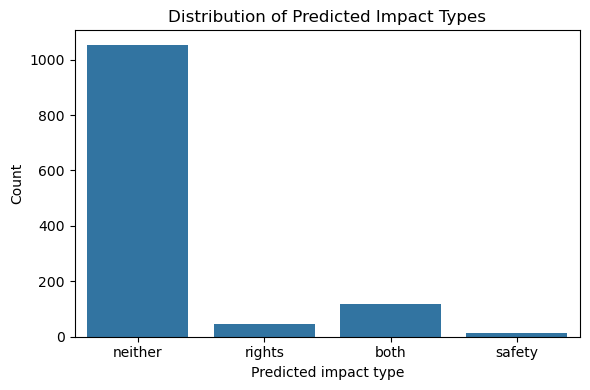

In [ ]:
# Step 10: Distribution of predicted impact types
# Usefulness: Shows Deloitte the overall "risk profile" of the AI inventory
# (how many cases fall into neither/rights/safety/both according to the model).

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df_scored, x="model_predicted_class")
plt.title("Distribution of Predicted Impact Types")
plt.xlabel("Predicted impact type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


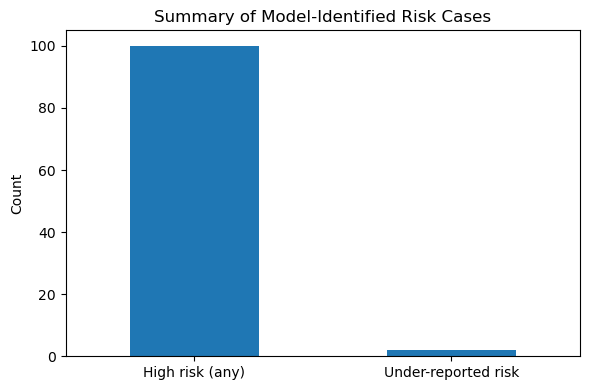

In [ ]:
# Step 11: High-risk and under-reported counts
# Usefulness: Highlights how many AI systems the model flags as priority review
# and where agencies may have reported "neither" despite model-detected risks.

risk_counts = pd.Series({
    "High risk (any)": df_scored["flag_any_high_risk"].sum(),
    "Under-reported risk": df_scored["flag_underreported_risk"].sum()
})

plt.figure(figsize=(6, 4))
risk_counts.plot(kind="bar")
plt.title("Summary of Model-Identified Risk Cases")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

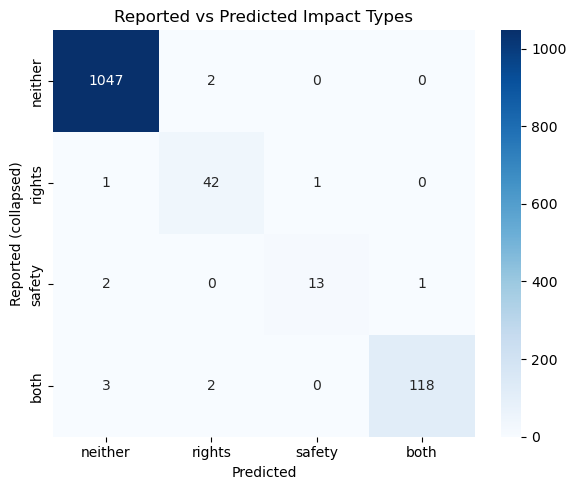

In [ ]:
# Step 12: Confusion matrix heatmap
# Usefulness: Shows where agency-reported labels and model predictions align or differ.
# This helps Deloitte identify reporting gaps, ambiguous categories, and oversight issues.

from sklearn.metrics import confusion_matrix

# Collapsed reported labels ensure consistency with model classes
y_true = df_scored["reported_collapsed"]
y_pred = df_scored["model_predicted_class"]

labels = ["neither", "rights", "safety", "both"]

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Reported vs Predicted Impact Types")
plt.xlabel("Predicted")
plt.ylabel("Reported (collapsed)")
plt.tight_layout()
plt.show()


### Why We Built This Scoring + Flagging Pipeline

Our goal was to turn the text classifier from Notebook 07/08 into a practical risk triage tool that Deloitte and federal reviewers could actually use.

We focused on the merged narrative field `text_clean` because that is where agencies describe what the system does, how it is used, and whom it affects — the core signals for rights and safety risk. We kept the model simple (TF–IDF + Logistic Regression) because it performed best on macro F1, provides calibrated class probabilities, and is easy to explain and audit in a governance context.

Notebook 09 extends the inference function to the full dataset: we score every use case, attach predicted impact type and class probabilities, and then convert those probabilities into simple flags using thresholds. This allows us to identify (1) high-risk systems that warrant priority human review and (2) potential under-reported cases where the model predicts rights/safety/both but the agency reported “neither.”

Finally, we add a small set of summary plots (distribution of predicted impact types, counts of high-risk and under-reported cases, and a confusion-matrix heatmap) to give a compact view of how the model sees the risk landscape and where reporting and model predictions align or diverge. Together, this provides a clear, governance-friendly proof of concept: a lightweight AI tool that helps surface and prioritize risky AI use cases for further review.


## Model Justification and Proof-of-Concept Narrative

### A. Problem and Objective

Agencies self-report whether their AI systems have rights or safety impacts, but this information is often provided in free-text form and can be inconsistent across agencies. Deloitte’s guiding question is whether AI methods can help reviewers identify potentially risky systems more efficiently and detect gaps in reporting.

Our goal was therefore not simply to build a classifier, but to create a **triage tool**: a lightweight, governance-friendly model that reads narrative descriptions, predicts impact type, and highlights which systems warrant closer human review.

---

### B. Modelling Design Choices

We focused our modelling on the merged narrative field `text_clean`. This field combines the system purpose, expected benefits, outputs, and sometimes listed risks—precisely the sections where rights- and safety-relevant context naturally appears. Using only this field keeps the model interpretable and aligned with how federal reviewers assess impact today.

For the model, we used **TF–IDF + Logistic Regression**:

- TF–IDF with word 1–2-grams captures both keywords and short phrases relevant to rights or safety risk.
- Logistic Regression delivered the strongest macro-F1 across our tested models and performed consistently on minority classes.
- Its ability to produce **probabilities** makes it useful for downstream thresholding and risk flagging.
- It is interpretable and easy to audit, which aligns with public-sector requirements for transparency and governance.

This model is intentionally simple: it provides reliable signals while remaining fully explainable to non-technical reviewers.

---

### C. From Model to Triage Tool: Batch Scoring, Thresholds, and Flags

Notebook 08 produced a clean inference function that returns a predicted class and class probabilities for each new use case. Notebook 09 scales this up into a **batch scoring pipeline**, applying the model to all use cases in the inventory.

To make the outputs actionable, we convert probabilities into **threshold-based flags**. These include:

- `flag_rights_high`
- `flag_safety_high`
- `flag_both_high`
- `flag_any_high_risk`

This approach transforms model outputs into straightforward decision signals: which systems should be reviewed first based on their likelihood of involving rights or safety considerations.

We further introduced a `flag_underreported_risk` by comparing predicted classes to **collapsed reported impact labels**. This flag identifies cases where the model predicts `rights`, `safety`, or `both`, but the agency reports “neither.” This directly addresses Deloitte’s question around whether safety and security impacts are adequately reported across agencies.

---

### D. Visualizations and Their Usefulness

We created three compact visual summaries to support reviewer interpretation:

1. **Distribution of predicted impact types**  
   Shows the model-identified risk profile of the AI inventory across the four classes.

2. **High-risk and under-reported counts**  
   Quickly communicates how many systems the model flags as high priority and how many may require follow-up due to potential under-reporting.

3. **Confusion-matrix heatmap (reported vs predicted)**  
   Highlights where agency reporting and model predictions align or differ. This helps identify potential oversight gaps, ambiguous categories, and areas where reporting may need standardization.

These visualizations are intentionally minimal and policy-focused rather than technical.

---

### E. Why This Is a Useful Proof of Concept

The end product is a functioning prototype of an AI-assisted review workflow:

- It ingests existing narrative descriptions already provided by agencies.
- It predicts impact type in a transparent and interpretable manner.
- It flags high-risk and potentially under-reported systems for prioritized human review.
- It produces clear outputs that can support decision-making without requiring a complex interface or dashboard.

This aligns closely with Deloitte’s objective for the capstone: demonstrate how AI can enhance federal oversight by triaging risk, improving consistency, and helping reviewers focus their attention where it matters most.

